In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(333)

df = pd.read_csv('./data/merged_probs_odds.csv') # labels: "home wins" -> 1; "draw": 0; "away" -> -1
df = df.sort_values("date_x", ascending = True)

rename_dict = {"date_x":"date", "prob_tie": "prob_draw", "label":"result"}
df = df.rename(columns=rename_dict)

keep_cols = ['date', 'home_team', 'away_team', 'spi1', 'spi2', 'prob_home', 'prob_draw', 'prob_away', 'odds_home', 'odds_draw',
             'odds_away', 'proj_home_score', 'proj_away_score', 'home_goals', 'away_goals', 'result']
# df = df[keep_cols]
df['result'] = df['result'].map({1: 0, -1: 2, 0: 1}) # 0 = home; 1 = draw; 2 = away
df.tail()

,date,date_y,year,country,league,home_team,away_team,spi1,spi2,prob_home,prob_draw,prob_away,odds_home,odds_draw,odds_away,proj_home_score,proj_away_score,home_goals,away_goals,result
10740,2023-05-08,2/4/2022,2022,England,English League Championship,Birmingham,Sheffield United,38.07,54.97,0.3132,0.2782,0.4086,3.86,3.41,2.00,1.09,1.29,1,2,2
10738,2023-05-08,8/5/2023,2023,Argentina,Argentina Primera Division,San Lorenzo,Defensa y Justicia,45.00,43.75,0.4500,0.3056,0.2445,2.17,2.98,3.75,1.21,0.81,0,0,1
10741,2023-05-09,9/5/2023,2023,Sweden,Swedish Allsvenskan,Hammarby,Mjallby,37.31,21.67,0.5602,0.2552,0.1847,1.67,3.74,5.26,1.69,0.86,0,0,1
10742,2023-05-10,11/5/2023,2023,Brazil,Brasileiro Série A,Cruzeiro,Fluminense,45.37,58.56,0.3419,0.2535,0.4046,2.62,3.15,2.76,1.38,1.52,0,2,2
10743,2023-05-14,5/14/2022,2022,Italy,Italy Serie A,Verona,Torino,52.92,66.14,0.3544,0.3083,0.3373,2.31,3.48,3.10,1.07,1.04,0,1,2


In [2]:
from tqdm import tqdm

def make_trajectories(df, trajectory_len=30, keep_cols=['date', 'home_team', 'away_team', 'spi1', 'spi2', 'prob_home',
                                                        'prob_draw', 'prob_away', 'odds_home', 'odds_draw', 'odds_away',
                                                        'proj_home_score', 'proj_away_score', 'result']):
    num_traj = int(df.shape[0] // trajectory_len)
    trajectories = []
    for _ in tqdm(range(num_traj)):
        df = df.sample(frac=1.0) # shuffle
        traj = df.iloc[:trajectory_len] # keep first {traj_len} random games
        traj = traj.sort_values(by='date', ascending=True) # make game sample chronologic
        trajectories.append(traj[keep_cols])
    return trajectories

In [3]:
traj_list = make_trajectories(df)

100%|██████████| 358/358 [00:00<00:00, 407.64it/s]


In [4]:
train_list, test_list = traj_list[:300], traj_list[300:]
train_df, test_df = pd.concat(train_list), pd.concat(test_list)
train_df

,date,home_team,away_team,spi1,spi2,prob_home,prob_draw,prob_away,odds_home,odds_draw,odds_away,proj_home_score,proj_away_score,result
544,2017-08-09,Ponte Preta,Fluminense,44.82,47.47,0.4639,0.2654,0.2707,2.17,3.27,3.29,1.43,1.03,1
812,2017-09-16,Guingamp,Lille,57.25,56.35,0.4599,0.2814,0.2587,2.15,3.30,3.50,1.42,0.99,0
970,2017-09-30,Udinese,Sampdoria,57.69,62.93,0.3906,0.2789,0.3305,2.70,3.25,2.60,1.40,1.26,0
2073,2018-08-15,Vissel Kobe,Sanfrecce Hiroshima,44.82,47.54,0.3681,0.2624,0.3695,2.42,3.40,2.78,1.26,1.27,1
2271,2018-09-02,Albacete,Cordoba,26.50,28.96,0.4488,0.2632,0.2881,1.95,3.10,4.33,1.63,1.26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8884,2022-06-24,Internacional,Coritiba,53.45,43.02,0.5391,0.2385,0.2223,1.76,3.57,4.70,1.81,1.08,0
9052,2022-08-03,Portland Timbers,Nashville SC,43.01,41.71,0.4716,0.2459,0.2825,2.22,3.56,3.03,1.73,1.29,1
9725,2022-10-01,Ajax,Go Ahead Eagles,85.83,43.19,0.9058,0.0727,0.0216,1.08,11.29,25.19,3.28,0.40,1
9971,2022-10-16,Real Madrid,Barcelona,87.48,87.14,0.4588,0.2370,0.3042,2.28,3.64,3.05,1.90,1.52,0


In [12]:
from oddsgym.envs.soccer import ThreeWaySoccerOddsEnv
from oddsgym.envs.base_percentage import BasePercentageOddsEnv

Trial #4: Fixed Baselines, train policy using PPO2

Sources:

https://colab.research.google.com/drive/1eqODB6TYWUaPq-SG1LD8kVcw1VMqEUyU#scrollTo=juMw2p58Jv8r 

https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/3_multiprocessing.ipynb#scrollTo=AvO5BGrVv2Rk 

https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html

In [13]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines import PPO2
from stable_baselines.common import set_global_seeds

Trial #5: Percentage Baselines, train policy using PPO2

In [11]:
def make_perc_env(train_trajectories, train_feats, env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    :param train_trajectories: (list of DataFrames) list with the trajectories to be used for training
    :param train_feats (list of str) the name of the features in the DFs above for the agent to learn from
    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        main_df = train_trajectories[env_id][train_feats].to_numpy()
        results_df = train_trajectories[env_id]["result"].tolist()
        env = BasePercentageOddsEnv(main_df=main_df, odds_column_names=["odds_home", "odds_draw", "odds_away"], 
                                    num_possible_outcomes=3, results=results_df)
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

In [12]:
#Train model and append total ending rewards 

train_feats = ['spi1', 'spi2', 'prob_home', 'prob_draw', 'prob_away', 'odds_home', 'odds_draw', 'odds_away',
               'proj_home_score', 'proj_away_score']

eps_length = train_list[0].shape[0]
num_traj = len(train_list)
rewards = []

learning_env = DummyVecEnv([make_perc_env(train_list, train_feats, i, i) for i in range(num_traj)])
model = PPO2(MlpPolicy, learning_env, verbose=1)
obs = learning_env.reset()
model.learn(total_timesteps=3000)

In [13]:
INITS = 1000

#Test model and append total ending rewards 
eps_length = test_list[0].shape[0]
num_traj = len(test_list)
rewards = np.zeros((num_traj, INITS))

for j in range(INITS):
    for i in range(num_traj):
        odds_df = test_list[i][["home", "draw",	"away"]].to_numpy()
        results_df = test_list[i]["result"].tolist()
        env = BasePercentageOddsEnv(odds_df, ["home", "draw", "away"], results_df, starting_bank=1000)
        obs = env.reset()
        for l in range(eps_length):
            #print(env.render())
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
            if done:
                rewards[i][j] = info['balance']
                break

rewards = np.mean(rewards, axis = 1)
print(sum(rewards)/rewards.shape[0])
print(max(rewards))

KeyError: "None of [Index(['home', 'draw', 'away'], dtype='object')] are in the [columns]"

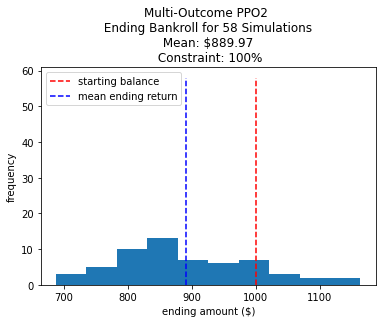

In [28]:
mean_return = round(np.mean(rewards), 2)
NUM_SIMULATIONS = rewards.shape[0]
CONSTRAINT = 1
plt.hist(rewards)
plt.title(f'Multi-Outcome PPO2 \n Ending Bankroll for {NUM_SIMULATIONS} Simulations \n Mean: ${mean_return} \n Constraint: {100*CONSTRAINT}%')
plt.plot([1000, 1000], [0, NUM_SIMULATIONS], 'r--', label='starting balance')
plt.plot([mean_return, mean_return], [0, NUM_SIMULATIONS], 'b--', label='mean ending return')
plt.legend(loc='best')
plt.xlabel('ending amount ($)')
plt.ylabel('frequency')
plt.show()

Trial #6: Percentage Baselines, train policy using PPO2, adding a 10% constraint

In [29]:
def make_perc_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        odds_df = train_list[env_id][["home", "draw",	"away"]].to_numpy()
        results_df = train_list[env_id]["result"].tolist()
        env = BasePercentageOddsEnv(odds_df, ["home", "draw", "away"], results_df)
        # Important: use a different seed for each environment
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

In [30]:
#Train model and append total ending rewards 
eps_length = train_list[0].shape[0]
num_traj = len(train_list)
rewards = []

learning_env = DummyVecEnv([make_perc_env(i, i) for i in range(num_traj)])
model = PPO2(MlpPolicy, learning_env, verbose=1)
obs = learning_env.reset()
model.learn(total_timesteps=3000)